In [2]:
import pandas as pd

# 1. Load the cleaned data
df = pd.read_parquet("../data/filtered_articles_date_cleaned.parquet")

# 2. Flag readable vs unreadable
df["date_readable"] = df["publish_date_cleaned"].notna()

# 3. Per-source aggregation
stats = (
    df.groupby("source_domain")
      .agg(
         total_articles   = ("date_readable", "size"),
         readable_dates   = ("date_readable", "sum")
      )
      .reset_index()
)
stats["unreadable_dates"] = stats["total_articles"] - stats["readable_dates"]
stats["pct_readable"]     = 100 * stats["readable_dates"] / stats["total_articles"]

# 4. Overall summary
overall = pd.DataFrame({
    "total_articles":   [len(df)],
    "readable_dates":   [df["date_readable"].sum()],
    "unreadable_dates":[ (~df["date_readable"]).sum() ],
    "pct_readable":     [df["date_readable"].mean() * 100]
})

# 5. Print results
print("Per-Source Date Readability Stats:")
print(stats.sort_values("pct_readable").to_string(index=False))
print("\nOverall Date Readability Summary:")
print(overall.to_string(index=False))


Per-Source Date Readability Stats:
     source_domain  total_articles  readable_dates  unreadable_dates  pct_readable
 indianexpress.com            2818            2622               196     93.044713
           bbc.com            2376            2253               123     94.823232
      newsweek.com            2163            2153                10     99.537679
    abcnews.go.com             747             747                 0    100.000000
           cnn.com            2085            2085                 0    100.000000
   dailymail.co.uk            2990            2990                 0    100.000000
        apnews.com            3584            3584                 0    100.000000
          cnbc.com             582             582                 0    100.000000
       foxnews.com            2749            2749                 0    100.000000
     express.co.uk            1919            1919                 0    100.000000
 independent.co.uk            6511            6511  

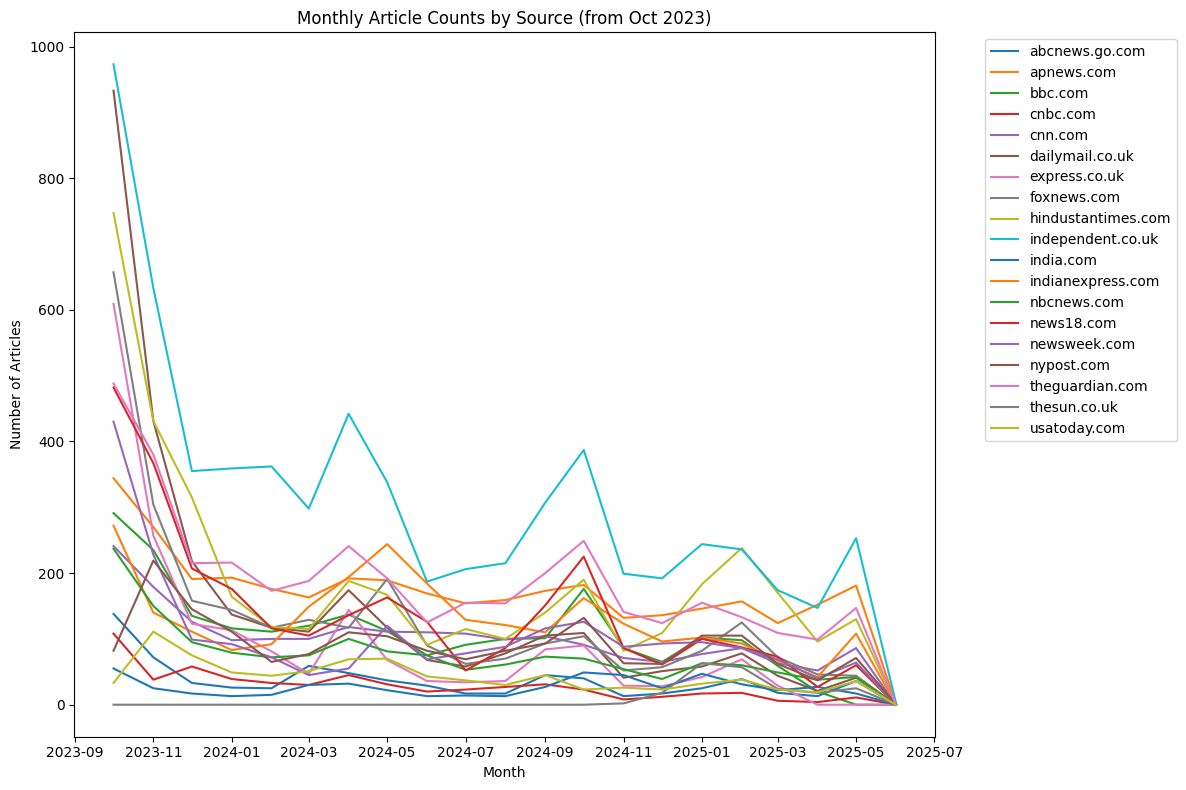

In [6]:
import matplotlib.pyplot as plt

# Filter counts to start from October 2023
counts_filtered = counts.loc[counts.index >= "2023-10-01"]

plt.figure(figsize=(12, 8))
for src in counts_filtered.columns:
    plt.plot(counts_filtered.index, counts_filtered[src], label=src)
plt.xlabel("Month")
plt.ylabel("Number of Articles")
plt.title("Monthly Article Counts by Source (from Oct 2023)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [8]:
df_articles= pd.read_parquet("../data/filtered_articles_date_cleaned.parquet")
df_image_index= pd.read_parquet("../data/blip_captioned_images.parquet")

print(df_articles.columns)
print(df_image_index.columns)

Index(['id', 'title', 'description', 'text', 'url', 'source_domain',
       'date_published', 'authors', 'keywords', 'matched_keywords',
       'predicted_label', 'label_index', 'publish_date_cleaned',
       'date_readable'],
      dtype='object')
Index(['image_id', 'article_id', 'source_domain', 'image_url', 'caption',
       'local_img_path', 'blip_caption'],
      dtype='object')


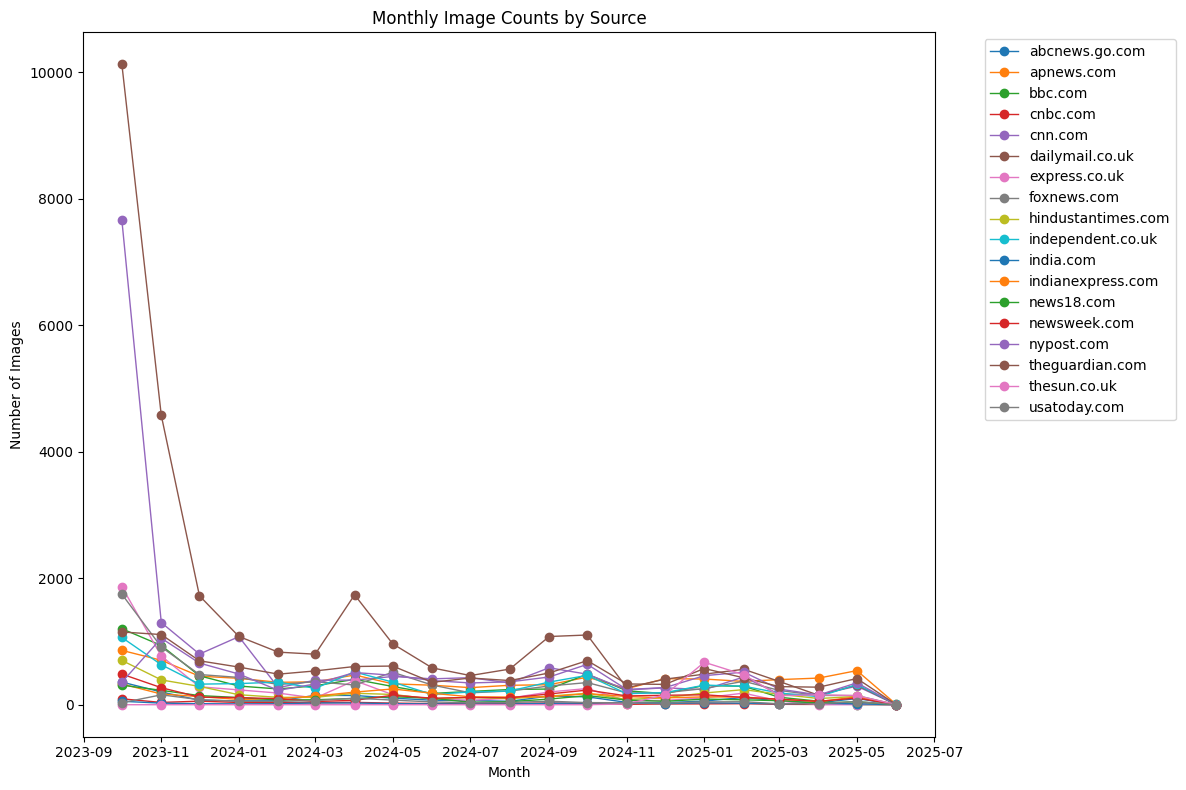

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load both tables
df_articles    = pd.read_parquet("../data/filtered_articles_date_cleaned.parquet")
df_image_index = pd.read_parquet("../data/blip_captioned_images.parquet")

# 2. Keep only articles with a parsed date
df_articles = df_articles[df_articles["publish_date_cleaned"].notna()]

# 3. Merge images ← articles, suffixing to avoid collision
df = df_image_index.merge(
    df_articles[["id","publish_date_cleaned","source_domain"]],
    left_on="article_id",
    right_on="id",
    how="inner",
    suffixes=("_img","_art")
)

# 4. Rename the image‐side domain to a uniform name
df = df.rename(columns={"source_domain_img":"source_domain"})

# 5. Drop the article‐side domain (optional)
df = df.drop(columns=["source_domain_art","id"])

# 6. Extract Year-Month bins
df["year_month"] = (
    pd.to_datetime(df["publish_date_cleaned"])
      .dt.to_period("M")
      .dt.to_timestamp()
)

# 7. Count images per source per month
counts = (
    df
    .groupby(["year_month","source_domain"])
    .size()
    .unstack("source_domain")
    .fillna(0)
)

# 8. (Optional) restrict to from Oct 2023
counts = counts.loc[counts.index >= "2023-10-01"]

# 9. Plot
plt.figure(figsize=(12, 8))
for src in counts.columns:
    plt.plot(counts.index, counts[src], marker="o", linewidth=1, label=src)

plt.xlabel("Month")
plt.ylabel("Number of Images")
plt.title("Monthly Image Counts by Source")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [12]:
import pandas as pd

# Load merged image + article table (with cleaned dates & source_domain)
df = pd.read_parquet("../data/blip_captioned_images.parquet")\
       .merge(
           pd.read_parquet("../data/filtered_articles_date_cleaned.parquet")[["id","publish_date_cleaned"]],
           left_on="article_id", right_on="id", how="left"
        )

# Keep only rows with a valid date
df = df[df["publish_date_cleaned"].notna()]

# Extract month
df["year_month"] = pd.to_datetime(df["publish_date_cleaned"])\
                      .dt.to_period("M")\
                      .dt.to_timestamp()

# Filter to Guardian & CNN
df_gc = df[df["source_domain"].isin(["theguardian.com","cnn.com"])]

# Group & count
monthly = (
    df_gc
    .groupby(["source_domain","year_month"])
    .size()
    .reset_index(name="image_count")
)

# Pivot for easy inspection
pivot = monthly.pivot(index="year_month", columns="source_domain", values="image_count").fillna(0)

print(pivot.sort_values(by="theguardian.com", ascending=False).head(10))
print(pivot.sort_values(by="cnn.com", ascending=False).head(10))


source_domain  cnn.com  theguardian.com
year_month                             
2023-10-01        7659             1150
2023-11-01        1298             1109
2024-10-01         482              697
2023-12-01         800              694
2024-05-01         446              611
2024-04-01         389              604
2024-01-01        1076              595
2025-01-01         239              572
2024-03-01         387              534
2024-09-01         584              502
source_domain  cnn.com  theguardian.com
year_month                             
2023-10-01        7659             1150
2023-11-01        1298             1109
2024-01-01        1076              595
2023-12-01         800              694
2024-09-01         584              502
2024-10-01         482              697
2024-05-01         446              611
2025-02-01         438              425
2024-07-01         427              422
2024-06-01         409              354


In [16]:
import pandas as pd

# 1. Load both tables
df_img = pd.read_parquet("../data/blip_captioned_images.parquet")
df_art = pd.read_parquet("../data/filtered_articles_date_cleaned.parquet")[
    ["id","url","publish_date_cleaned","source_domain"]
]

# 2. Merge images ← articles, keeping the article’s source_domain
df = df_img.merge(
    df_art,
    left_on="article_id",
    right_on="id",
    how="inner",
    suffixes=("_img","_art")
)

# 3. Rename so we have a single source_domain column
df = df.rename(columns={"source_domain_art":"source_domain"}).drop(columns=["source_domain_img","id"])

# 4. Drop any rows without a cleaned date
df = df[df["publish_date_cleaned"].notna()]

# 5. Compute year_month
df["year_month"] = (
    pd.to_datetime(df["publish_date_cleaned"])
      .dt.to_period("M")
      .dt.to_timestamp()
)

# 6. Now define a helper to show top‐image articles for a given source/month
def top_articles(src, ym, top_n=10):
    sub = df[(df["source_domain"]==src) & (df["year_month"]==pd.Timestamp(ym))]
    vc = sub["url"].value_counts().head(top_n)
    print(f"\n=== {src} top {top_n} articles for {ym} ({len(sub)} images) ===")
    print(vc.to_string())

# 7. Invoke it for the spike months:
top_articles("cnn.com",        "2023-10-01", top_n=10)
top_articles("cnn.com",        "2023-11-01", top_n=10)
top_articles("theguardian.com","2023-10-01", top_n=10)
top_articles("theguardian.com","2023-11-01", top_n=10)



=== cnn.com top 10 articles for 2023-10-01 (7659 images) ===
url
https://www.cnn.com/2023/10/24/middleeast/israel-hamas-gaza-war-tuesday-intl-hnk/index.html     370
https://www.cnn.com/2023/10/09/middleeast/israel-gaza-hamas-fighting-monday-intl-hnk            359
https://www.cnn.com/2023/10/07/middleeast/sirens-israel-rocket-attack-gaza-intl-hnk             357
https://www.cnn.com/2023/10/23/middleeast/israel-gaza-hamas-war-monday-intl-hnk                 357
https://www.cnn.com/2023/10/22/middleeast/israel-gaza-hamas-war-sunday-intl-hnk                 356
https://www.cnn.com/2023/10/10/middleeast/gaza-complete-siege-israel-intl                       355
https://www.cnn.com/2023/10/11/middleeast/israel-gaza-hamas-war-wednesday-intl-hnk              355
https://www.cnn.com/2023/10/17/middleeast/israel-gaza-rafah-crossing-week-2-tuesday-intl-hnk    350
https://www.cnn.com/2023/10/10/middleeast/israel-gaza-siege-hamas-tuesday-intl-hnk              347
https://www.cnn.com/2023/10/18/mid


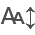

In [3]:
# Enable itables for interactive tables
from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=True)


In [5]:
import duckdb

con = duckdb.connect()
high_vol_cnn = con.execute("""
    SELECT 
      img.article_id,
      art.url AS article_url,
      art.publish_date_cleaned,
      COUNT(*) AS image_count
    FROM '../data/blip_captioned_images.parquet' AS img
    JOIN '../data/filtered_articles_date_cleaned.parquet' AS art
      ON img.article_id = art.id
    WHERE art.source_domain = 'cnn.com'
      AND art.publish_date_cleaned IS NOT NULL
    GROUP BY img.article_id, art.url, art.publish_date_cleaned
    HAVING COUNT(*) > 344
    ORDER BY image_count DESC
""").fetchdf()

show(high_vol_cnn)


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [9]:
import duckdb

con = duckdb.connect()
df_under = con.execute("""
    WITH counts AS (
      SELECT
        img.article_id,
        art.url               AS article_url,
        art.publish_date_cleaned,
        COUNT(*)              AS image_count
      FROM '../data/blip_captioned_images.parquet' AS img
      JOIN '../data/filtered_articles_date_cleaned.parquet' AS art
        ON img.article_id = art.id
      WHERE art.source_domain = 'cnn.com'
        AND art.publish_date_cleaned IS NOT NULL
      GROUP BY img.article_id, art.url, art.publish_date_cleaned
    )
    SELECT *
    FROM counts
    WHERE image_count < 344
      AND image_count = (SELECT MAX(image_count) FROM counts WHERE image_count < 344)
""").fetchdf()

show(df_under)


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [10]:
import duckdb
import pandas as pd

# 1. Connect to DuckDB
con = duckdb.connect()

# 2. Run the same logic
top10 = con.execute("""
    WITH cnn_imgs AS (
      SELECT img.image_url, img.article_id
      FROM '../data/blip_captioned_images.parquet' AS img
      JOIN '../data/filtered_articles_date_cleaned.parquet' AS art
        ON img.article_id = art.id
      WHERE art.source_domain = 'cnn.com'
    ),
    img_counts AS (
      SELECT image_url, COUNT(DISTINCT article_id) AS article_count
      FROM cnn_imgs
      GROUP BY image_url
    ),
    allowed_imgs AS (
      SELECT image_url
      FROM img_counts
      WHERE article_count <= 4
    )
    SELECT
      ci.article_id,
      art.url               AS article_url,
      art.publish_date_cleaned,
      COUNT(*)              AS image_count
    FROM cnn_imgs ci
    JOIN allowed_imgs ai   USING(image_url)
    JOIN '../data/filtered_articles_date_cleaned.parquet' AS art
      ON ci.article_id = art.id
    GROUP BY ci.article_id, art.url, art.publish_date_cleaned
    ORDER BY image_count DESC
    LIMIT 10;
""").fetchdf()

# 3. Print the result
show(top10)


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

# 1. Load image and article metadata
df_img = pd.read_parquet("data/blip_captioned_images.parquet")
df_art = pd.read_parquet("data/filtered_articles_date_cleaned.parquet")[["id", "url", "source_domain"]]

# 2. Filter to CNN articles only
cnn_articles = df_art[df_art["source_domain"] == "cnn.com"]

# 3. Build a mapping of article_id -> set of gallery image URLs
article_gallery_urls = {}
for article_id, article_url in cnn_articles.itertuples(index=False):
    try:
        resp = requests.get(article_url, timeout=10)
        resp.raise_for_status()
        soup = BeautifulSoup(resp.text, "html.parser")
        gallery_imgs = set()
        for gallery in soup.find_all("div", class_="gallery-inline"):
            # find all <img> within the gallery
            for img_tag in gallery.find_all("img"):
                src = img_tag.get("src") or img_tag.get("data-src")
                if src:
                    # normalize URL (strip query params)
                    gallery_imgs.add(src.split("?")[0])
        if gallery_imgs:
            article_gallery_urls[article_id] = gallery_imgs
    except Exception as e:
        print(f"Error fetching {article_url}: {e}")
    # polite pause
    time.sleep(0.1)

# 4. Label each image as outside_article if it appears in the gallery set
def is_outside(row):
    if row["source_domain"] != "cnn.com":
        return False
    gallery = article_gallery_urls.get(row["article_id"], set())
    img_url = row["image_url"].split("?")[0]
    return img_url in gallery

df_img["outside_article"] = df_img.apply(is_outside, axis=1)

# 5. Save updated Parquet
df_img.to_parquet("data/blip_captioned_images_labeled.parquet", index=False)

print("Labeled images and saved to data/blip_captioned_images_labeled.parquet")


In [11]:
# List of URLs to look up
urls = [
    "https://www.cnn.com/2023/10/24/middleeast/israel-hamas-gaza-war-tuesday-intl-hnk/index.html",
    "https://www.cnn.com/2023/11/03/middleeast/israel-cuts-ties-gaza-permit-workers-intl-hnk",
    "https://www.cnn.com/2024/05/08/politics/report-looms-biden-israel-international-law"
]

# Search for matching article_ids in high_vol_cnn and df_under
matches = []
for url in urls:
    # Try to match with or without trailing slash
    row = high_vol_cnn[high_vol_cnn["article_url"].str.startswith(url)]
    if row.empty:
        row = df_under[df_under["article_url"].str.startswith(url)]
    if not row.empty:
        matches.append((url, row.iloc[0]["article_id"]))
    else:
        matches.append((url, None))

for url, article_id in matches:
    print(f"URL: {url}\nArticle ID: {article_id}\n")

URL: https://www.cnn.com/2023/10/24/middleeast/israel-hamas-gaza-war-tuesday-intl-hnk/index.html
Article ID: 42b1a51f-2857-4b7f-b423-e9261bf0e72d

URL: https://www.cnn.com/2023/11/03/middleeast/israel-cuts-ties-gaza-permit-workers-intl-hnk
Article ID: f5e63db0-d0aa-4d8c-8cdf-1539f09d69b9

URL: https://www.cnn.com/2024/05/08/politics/report-looms-biden-israel-international-law
Article ID: cbacec07-ab6e-4b19-9631-9c164520db95



In [3]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time

# --- CONFIG ---
IMAGE_PARQUET   = "../data/blip_captioned_images.parquet"
ARTICLE_PARQUET = "../data/filtered_articles_date_cleaned.parquet"
HEADERS         = {"User-Agent": "Mozilla/5.0"}
TEST_IDS        = [
    "42b1a51f-2857-4b7f-b423-e9261bf0e72d",
    "f5e63db0-d0aa-4d8c-8cdf-1539f09d69b9",
    "cbacec07-ab6e-4b19-9631-9c164520db95"
]

# 1. Load your tables
df_img = pd.read_parquet(IMAGE_PARQUET, engine="pyarrow")[["article_id", "image_url", "caption"]]
df_art = pd.read_parquet(ARTICLE_PARQUET, engine="pyarrow")[["id", "url", "source_domain"]]

# 2. Restrict to the three test articles (and CNN domain)
df_test_art = (
    df_art
    .loc[lambda d: d["id"].isin(TEST_IDS) & (d["source_domain"]=="cnn.com")]
    .rename(columns={"id":"article_id", "url":"article_url"})
)

# 3. Build gallery‐image map for those articles
gallery_map = {}
for article_id, article_url in zip(df_test_art["article_id"], df_test_art["article_url"]):
    try:
        resp = requests.get(article_url, headers=HEADERS, timeout=10)
        resp.raise_for_status()
        soup = BeautifulSoup(resp.text, "html.parser")
        urls = set()
        for div in soup.select("div.gallery-inline"):
            # any data-url attrs
            for tag in div.find_all(attrs={"data-url": True}):
                urls.add(tag["data-url"].split("?")[0])
            # any <img> inside
            for img in div.find_all("img"):
                src = img.get("src") or img.get("data-src") or ""
                urls.add(src.split("?")[0])
        gallery_map[article_id] = urls
    except Exception as e:
        print(f"[WARN] Could not fetch {article_url}: {e}")
    time.sleep(0.1)

# 4. Filter to images for those article_ids
df_test_img = df_img[df_img["article_id"].isin(TEST_IDS)].copy()

# 5. Merge in article_url
df_test = df_test_img.merge(df_test_art, on="article_id", how="left")

# 6. Label carousel images AND any w_250 thumbnails as outside_article
def is_outside(row):
    base = row["image_url"].split("?", 1)[0]
    in_gallery = base in gallery_map.get(row["article_id"], set())
    is_thumb250 = "w_250" in row["image_url"]
    return in_gallery or is_thumb250

df_test["outside_article"] = df_test.apply(is_outside, axis=1)

# 7. Print only the “inside” images per article
for aid, grp in df_test.groupby("article_id"):
    url = df_test_art.loc[df_test_art["article_id"] == aid, "article_url"].iloc[0]
    print(f"\n=== Article {aid} ({url}) ===")
    inside = grp[grp["outside_article"] == False]
    if not inside.empty:
        print(inside[["image_url", "caption", "outside_article"]].to_string(index=False))
    else:
        print("No images with outside_article == False")


=== Article 42b1a51f-2857-4b7f-b423-e9261bf0e72d (https://www.cnn.com/2023/10/24/middleeast/israel-hamas-gaza-war-tuesday-intl-hnk/index.html) ===
                                                                                                                              image_url                                                                                                                                              caption  outside_article
                  https://media.cnn.com/api/v1/images/stellar/prod/231024123520-gaza-drone-destruction-video.jpg?c=16x9&q=w_1280,c_fill                                                                                                                                                 None            False
                https://media.cnn.com/api/v1/images/stellar/prod/231023145908-gaza-drone-footage-destruction.jpg?c=16x9&q=w_1280,c_fill                                                                                                                 

In [4]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time

# --- CONFIG ---
IMAGE_PARQUET   = "../data/blip_captioned_images.parquet"
ARTICLE_PARQUET = "../data/filtered_articles_date_cleaned.parquet"
HEADERS         = {"User-Agent": "Mozilla/5.0"}
N_TEST          = 20
SLEEP_SEC       = 0.1  # polite pause between fetches
RANDOM_SEED     = 42

# 1. Load your tables
df_img = pd.read_parquet(IMAGE_PARQUET, engine="pyarrow")[["article_id", "image_url", "caption"]]
df_art = pd.read_parquet(ARTICLE_PARQUET, engine="pyarrow")[["id", "url", "source_domain"]]

# 2. Sample N random CNN article IDs
cnn_articles = df_art[df_art["source_domain"]=="cnn.com"]
test_ids = (
    cnn_articles["id"]
    .drop_duplicates()
    .sample(n=N_TEST, random_state=RANDOM_SEED)
    .tolist()
)
df_test_art = (
    cnn_articles[cnn_articles["id"].isin(test_ids)]
    .rename(columns={"id":"article_id", "url":"article_url"})
)

# 3. Build gallery‐image map for those sampled articles
gallery_map = {}
for aid, aurl in zip(df_test_art["article_id"], df_test_art["article_url"]):
    try:
        resp = requests.get(aurl, headers=HEADERS, timeout=10)
        resp.raise_for_status()
        soup = BeautifulSoup(resp.text, "html.parser")
        urls = set()
        # gather data-url entries
        for div in soup.select("div.gallery-inline"):
            for tag in div.find_all(attrs={"data-url": True}):
                urls.add(tag["data-url"].split("?",1)[0])
            for img in div.find_all("img"):
                src = img.get("src") or img.get("data-src") or ""
                urls.add(src.split("?",1)[0])
        gallery_map[aid] = urls
    except Exception as e:
        print(f"[WARN] Failed to fetch {aurl}: {e}")
    time.sleep(SLEEP_SEC)

# 4. Filter to images for those sampled article_ids
df_test_img = df_img[df_img["article_id"].isin(test_ids)].copy()

# 5. Merge in article_url for printing
df_test = df_test_img.merge(df_test_art, on="article_id", how="left")

# 6. Label carousel images and any w_250 thumbs as outside
def is_outside(row):
    base = row["image_url"].split("?",1)[0]
    in_gallery = base in gallery_map.get(row["article_id"], set())
    is_thumb250 = "w_250" in row["image_url"]
    return in_gallery or is_thumb250

df_test["outside_article"] = df_test.apply(is_outside, axis=1)

# 7. Print only the “inside” images per article
for aid, grp in df_test.groupby("article_id"):
    art_url = df_test_art.loc[df_test_art["article_id"]==aid, "article_url"].iloc[0]
    print(f"\n=== Article {aid} ({art_url}) ===")
    inside = grp[grp["outside_article"]==False]
    if not inside.empty:
        print(inside[["image_url","caption","outside_article"]].to_string(index=False))
    else:
        print("  No in‐article images found (all flagged outside_article=True)")



=== Article 0003b78e-a082-40ce-bf6e-bff0f4ddb04f (https://www.cnn.com/2024/02/23/politics/blinken-west-bank-settlements-international-law) ===
                                                                                                                                                   image_url                                                                                                                                                                                                            caption  outside_article
https://media.cnn.com/api/v1/images/stellar/prod/2024-02-23t163321z-1857548554-rc2g86ancy7b-rtrmadp-3-argentina-usa-blinken.JPG?c=16x9&q=h_833,w_1480,c_fill US Secretary of State Antony Blinken attends a joint press conference with Argentina's Foreign Minister Diana Mondino, at the Casa Rosada Presidential Palace, in Buenos Aires, Argentina, on Friday, February 23.            False

=== Article 02e7292d-4c8d-4ef8-9e20-e2f2e9252d0e (https://www.cnn.com/2025/04/07/midd

### Fix CNN image carousel

In [5]:
#!/usr/bin/env python3
"""
Label CNN carousel and thumbnail images in the full Parquet, adding logs after each article is processed.
Saves result to a new Parquet file.
"""

import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
import logging

# --- CONFIG ---
IMAGE_PARQUET   = "../data/blip_captioned_images.parquet"
ARTICLE_PARQUET = "../data/filtered_articles_date_cleaned.parquet"
OUTPUT_PARQUET  = "../data/blip_captioned_images_labeled.parquet"
HEADERS         = {"User-Agent": "Mozilla/5.0"}
DELAY_SEC       = 0.1  # polite pause between requests

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)

def main():
    logging.info("Loading Parquet files")
    df_img = pd.read_parquet(IMAGE_PARQUET, engine="pyarrow")
   
    df_art = pd.read_parquet(ARTICLE_PARQUET, engine="pyarrow")

    logging.info("Building list of CNN articles")
    cnn = (
        df_art[df_art["source_domain"] == "cnn.com"]
          [["id", "url"]]
          .drop_duplicates()
          .rename(columns={"id": "article_id", "url": "article_url"})
    )

    logging.info(f"Found {len(cnn)} CNN articles to process")

    # 3. Scrape each CNN page for gallery-inline images
    gallery_map = {}
    for aid, aurl in cnn.itertuples(index=False):
        try:
            resp = requests.get(aurl, headers=HEADERS, timeout=10)
            resp.raise_for_status()
            soup = BeautifulSoup(resp.text, "html.parser")
            urls = set()
            for div in soup.select("div.gallery-inline"):
                for tag in div.find_all(attrs={"data-url": True}):
                    urls.add(tag["data-url"].split("?", 1)[0])
                for img in div.find_all("img"):
                    src = img.get("src") or img.get("data-src") or ""
                    urls.add(src.split("?", 1)[0])
            gallery_map[aid] = urls
            logging.info(f"Processed article {aid}: found {len(urls)} gallery images")
        except Exception as e:
            logging.warning(f"Failed to fetch {aurl}: {e}")
        time.sleep(DELAY_SEC)

    # 4. Initialize flag and extract base_url
    df_img["outside_article"] = False
    df_img["base_url"] = df_img["image_url"].str.partition("?")[0]

    # 5. Flag CNN thumbnail variants (w_250)
    mask_cnn = df_img["article_id"].isin(gallery_map.keys())
    n_thumbs = mask_cnn & df_img["image_url"].str.contains("w_250", na=False)
    df_img.loc[n_thumbs, "outside_article"] = True
    logging.info(f"Flagged {n_thumbs.sum()} thumbnail (w_250) images as outside_article")

    # 6. Flag carousel images per article
    total_flagged = 0
    for aid, urls in gallery_map.items():
        mask = (df_img["article_id"] == aid) & (df_img["base_url"].isin(urls))
        count = mask.sum()
        if count:
            df_img.loc[mask, "outside_article"] = True
            total_flagged += count
        logging.info(f"Flagged {count} carousel images for article {aid}")
    
    # 7. Drop helper column and save
    df_img.drop(columns=["base_url"], inplace=True)
    df_img.to_parquet(OUTPUT_PARQUET, engine="pyarrow", index=False)
    logging.info(f"Saved labeled Parquet to {OUTPUT_PARQUET} (total carousel flagged: {total_flagged})")

if __name__ == "__main__":
    main()


2025-07-31 18:09:44 INFO: Loading Parquet files
2025-07-31 18:09:45 INFO: Building list of CNN articles
2025-07-31 18:09:45 INFO: Found 2085 CNN articles to process
2025-07-31 18:09:46 INFO: Processed article 99982d76-c059-4f0d-8373-4756fcbc2723: found 0 gallery images
2025-07-31 18:09:46 INFO: Processed article 6ddfddb4-bb58-4fdc-9874-caeb1524c2e7: found 0 gallery images
2025-07-31 18:09:46 INFO: Processed article 3e2fc781-4fca-45f5-84c7-626602308875: found 0 gallery images
2025-07-31 18:09:47 INFO: Processed article 05794b72-a290-4511-b7b0-50e2739ea59d: found 0 gallery images
2025-07-31 18:09:47 INFO: Processed article 615f350e-07e1-4887-a784-4af05f394980: found 0 gallery images
2025-07-31 18:09:47 INFO: Processed article c60bfb0d-552b-46f9-ae44-bb290d1fb3cf: found 0 gallery images
2025-07-31 18:09:48 INFO: Processed article e2e2e89d-02e1-43b4-86ad-ee6f9b3cf496: found 0 gallery images
2025-07-31 18:09:48 INFO: Processed article 3dbcc63a-3252-4f04-abef-776a118ed963: found 0 gallery im

In [5]:
import pandas as pd

# File paths
LABELED_PARQUET   = "../data/blip_captioned_images_labeled.parquet"
FILTERED_PARQUET  = "../data/blip_captioned_images_filtered.parquet"

# 1. Load the labeled DataFrame
df = pd.read_parquet(LABELED_PARQUET, engine="pyarrow")

# 2. Compute stats before filtering
stats_before = (
    df
    .groupby("source_domain")
    .agg(
        total_articles=("article_id", "nunique"),
        total_images=("article_id", "size")
    )
    .reset_index()
)

# 3. Filter out all outside_article == True rows
df_filtered = df[df["outside_article"] == False].copy()

# 4. Drop the outside_article column
df_filtered = df_filtered.drop(columns=["outside_article"])

# 5. Save the filtered DataFrame
df_filtered.to_parquet(FILTERED_PARQUET, engine="pyarrow", index=False)

# 6. Compute stats after filtering
stats_after = (
    df_filtered
    .groupby("source_domain")
    .agg(
        total_articles=("article_id", "nunique"),
        total_images=("article_id", "size")
    )
    .reset_index()
)

# 7. Display the results
print("Stats Before Filtering", stats_before)
print("Stats After Filtering", stats_after)

print(f"Dropped {len(df) - len(df_filtered)} images flagged outside_article; saved filtered Parquet to {FILTERED_PARQUET}")


Stats Before Filtering          source_domain  total_articles  total_images
0       abcnews.go.com             697          2029
1           apnews.com            3584          8380
2              bbc.com            2334          8212
3             cnbc.com             517           517
4              cnn.com            2019         16366
5      dailymail.co.uk            2912         28154
6        express.co.uk            1876          5180
7          foxnews.com            2649          8037
8   hindustantimes.com            3632          3738
9    independent.co.uk            3849          6854
10           india.com             428           428
11   indianexpress.com            2648          3069
12          news18.com            2020          2020
13        newsweek.com            2063          3008
14          nypost.com            1833          8477
15     theguardian.com            3880         10760
16        thesun.co.uk             207          1756
17        usatoday.com 

### Now run image publish analysis again

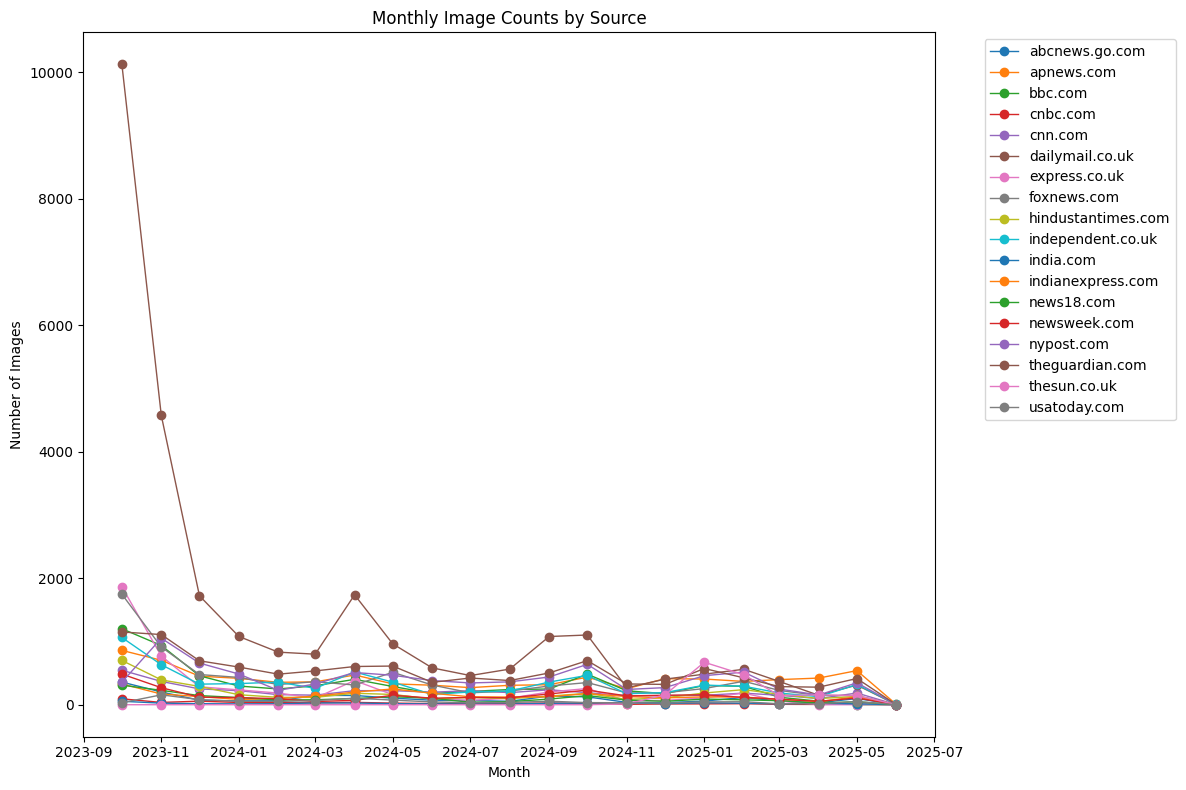

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load both tables
df_articles    = pd.read_parquet("../data/filtered_articles_date_cleaned.parquet")
df_image_index = pd.read_parquet("../data/blip_captioned_images.parquet")

# 2. Keep only articles with a parsed date
df_articles = df_articles[df_articles["publish_date_cleaned"].notna()]

# 3. Merge images ← articles, suffixing to avoid collision
df = df_image_index.merge(
    df_articles[["id","publish_date_cleaned","source_domain"]],
    left_on="article_id",
    right_on="id",
    how="inner",
    suffixes=("_img","_art")
)

# 4. Rename the image‐side domain to a uniform name
df = df.rename(columns={"source_domain_img":"source_domain"})

# 5. Drop the article‐side domain (optional)
df = df.drop(columns=["source_domain_art","id"])

# 6. Extract Year-Month bins
df["year_month"] = (
    pd.to_datetime(df["publish_date_cleaned"])
      .dt.to_period("M")
      .dt.to_timestamp()
)

# 7. Count images per source per month
counts = (
    df
    .groupby(["year_month","source_domain"])
    .size()
    .unstack("source_domain")
    .fillna(0)
)

# 8. (Optional) restrict to from Oct 2023
counts = counts.loc[counts.index >= "2023-10-01"]

# 9. Plot
plt.figure(figsize=(12, 8))
for src in counts.columns:
    plt.plot(counts.index, counts[src], marker="o", linewidth=1, label=src)

plt.xlabel("Month")
plt.ylabel("Number of Images")
plt.title("Monthly Image Counts by Source")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd

# 1. Load both tables
df_img = pd.read_parquet("../data/blip_captioned_images.parquet")
df_art = pd.read_parquet("../data/filtered_articles_date_cleaned.parquet")[
    ["id","url","publish_date_cleaned","source_domain"]
]

# 2. Merge images ← articles, keeping the article’s source_domain
df = df_img.merge(
    df_art,
    left_on="article_id",
    right_on="id",
    how="inner",
    suffixes=("_img","_art")
)

# 3. Rename so we have a single source_domain column
df = df.rename(columns={"source_domain_art":"source_domain"}).drop(columns=["source_domain_img","id"])

# 4. Drop any rows without a cleaned date
df = df[df["publish_date_cleaned"].notna()]

# 5. Compute year_month
df["year_month"] = (
    pd.to_datetime(df["publish_date_cleaned"])
      .dt.to_period("M")
      .dt.to_timestamp()
)

# 6. Now define a helper to show top‐image articles for a given source/month
def top_articles(src, ym, top_n=10):
    sub = df[(df["source_domain"]==src) & (df["year_month"]==pd.Timestamp(ym))]
    vc = sub["url"].value_counts().head(top_n)
    print(f"\n=== {src} top {top_n} articles for {ym} ({len(sub)} images) ===")
    print(vc.to_string())

# 7. Invoke it for the spike months:
top_articles("cnn.com",        "2023-10-01", top_n=10)
top_articles("cnn.com",        "2023-11-01", top_n=10)
top_articles("theguardian.com","2023-10-01", top_n=10)
top_articles("theguardian.com","2023-11-01", top_n=10)



=== cnn.com top 10 articles for 2023-10-01 (545 images) ===
url
https://www.cnn.com/2023/10/11/politics/presidents-israel-cnn                               12
https://www.cnn.com/2023/10/25/middleeast/satellite-images-gaza-destruction                 10
https://www.cnn.com/2023/10/16/middleeast/israel-gaza-hamas-week-2-monday-intl-hnk           9
https://www.cnn.com/2023/10/09/us/us-victims-israel-gaza                                     9
https://www.cnn.com/2023/10/11/world/global-protests-israel-hamas-war-intl-cmd               8
https://www.cnn.com/2023/10/09/middleeast/israel-hamas-music-festival-aftermath-intl-hnk     8
https://www.cnn.com/2023/10/09/middleeast/hamas-attack-strategy-israel-mime-intl             7
https://www.cnn.com/2023/10/12/world/israelis-returning-home-hamas-attack-intl               7
https://www.cnn.com/2023/10/14/middleeast/gaza-israel-evacuation-saturday-intl-hnk           7
https://www.cnn.com/2023/10/13/middleeast/israel-gaza-hamas-war-friday-intl-hnk 